C:\Users\aidan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aidan\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


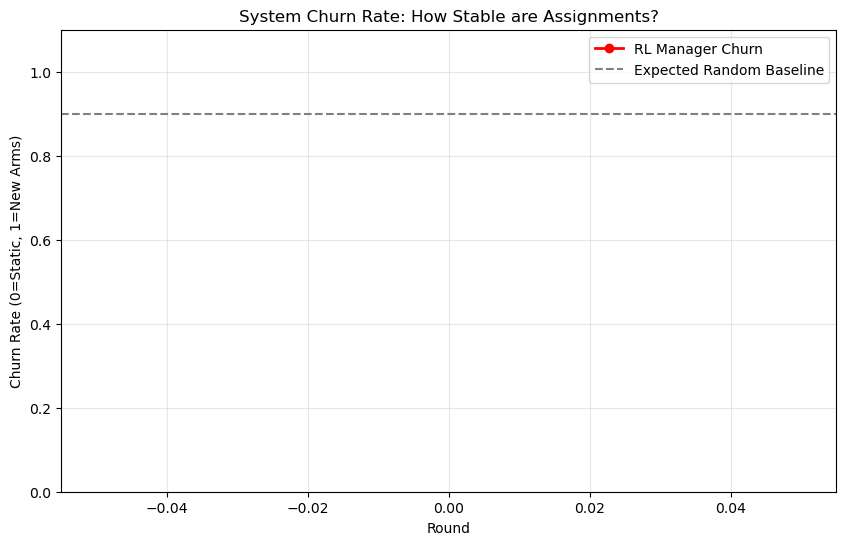

Average RL Churn: nan
Interpretation:
- If > 0.8: The RL is failing to learn (acting random).
- If < 0.4: The RL is locking in too early (Exploration Starvation).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

def parse_cell(cell_str):
    """Parses the string dictionary in the CSV back to a Python dict."""
    try:
        return ast.literal_eval(cell_str)
    except:
        return None

def calculate_churn_metrics(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0)
    
    # Identify agent columns (exclude 'Total_Payoff')
    agent_cols = [c for c in df.columns if "Agent_" in c]
    n_rounds = len(df)
    
    churn_per_round = []
    
    # We start from Round 1 (comparing to Round 0)
    for t in range(1, n_rounds):
        round_churns = []
        
        for agent in agent_cols:
            # Get data for Round t and Round t-1
            curr_data = parse_cell(df.at[t, agent])
            prev_data = parse_cell(df.at[t-1, agent])
            
            if curr_data and prev_data:
                # Get the set of assigned arms
                curr_arms = set(curr_data['assigned_arms'])
                prev_arms = set(prev_data['assigned_arms'])
                
                if len(curr_arms) == 0: continue
                
                # CHURN FORMULA:
                # The percentage of arms in the NEW set that were NOT in the OLD set.
                # If Churn = 0.0 -> Exact same arms (Perfect Stability)
                # If Churn = 1.0 -> Completely different arms (Total Chaos)
                
                # Intersection: Arms kept
                kept = curr_arms.intersection(prev_arms)
                
                # Churn = 1 - (Kept / Total Assigned)
                churn = 1.0 - (len(kept) / len(curr_arms))
                round_churns.append(churn)
        
        # Average churn across all 30 agents for this round
        avg_round_churn = np.mean(round_churns)
        churn_per_round.append(avg_round_churn)
        
    return churn_per_round

# --- RUN ANALYSIS ---

# 1. Analyze the RL Results
rl_churn = calculate_churn_metrics("final_rl_results(2).csv")

# 2. Analyze Random Results (If you have the file)
# If you don't have the CSV, I will generate a dummy baseline for comparison
# random_churn = calculate_churn_metrics("final_experiment_results.csv") 

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))

rounds = range(1, len(rl_churn) + 1)

plt.plot(rounds, rl_churn, marker='o', linewidth=2, color='red', label='RL Manager Churn')

# Add a reference line for what "Random" usually looks like
# In random assignment of 5 arms out of 50, the overlap is naturally very low.
# Expected Random Churn is approx 0.9 (90% new arms every time).
plt.axhline(y=0.9, color='gray', linestyle='--', label='Expected Random Baseline')

plt.title("System Churn Rate: How Stable are Assignments?")
plt.xlabel("Round")
plt.ylabel("Churn Rate (0=Static, 1=New Arms)")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# --- PRINT STATS ---
print(f"Average RL Churn: {np.mean(rl_churn):.4f}")
print("Interpretation:")
print("- If > 0.8: The RL is failing to learn (acting random).")
print("- If < 0.4: The RL is locking in too early (Exploration Starvation).")

In [5]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

def robust_parse(cell):
    """Robust parsing that handles NaNs and strings."""
    if pd.isna(cell):
        return None
    if isinstance(cell, dict):
        return cell # Already a dict (if pickle was used)
    try:
        return ast.literal_eval(str(cell))
    except:
        return None

def calculate_churn_metrics(csv_file_path):
    # Load with low_memory=False to prevent type guessing errors
    # quoting=1 ensures we handle the dictionary quotes correctly
    df = pd.read_csv(csv_file_path, index_col=0, low_memory=False)
    
    agent_cols = [c for c in df.columns if "Agent_" in c]
    if not agent_cols:
        print("Error: No 'Agent_' columns found in CSV.")
        return []

    churn_per_round = []
    
    print(f"Processing {len(df)} rounds for {len(agent_cols)} agents...")
    
    for t in range(1, len(df)):
        round_churns = []
        
        for agent in agent_cols:
            curr_raw = df.at[t, agent]
            prev_raw = df.at[t-1, agent]
            
            curr_data = robust_parse(curr_raw)
            prev_data = robust_parse(prev_raw)
            
            # Check if valid data exists
            if curr_data and prev_data:
                # Extract Assigned Arms
                curr_arms = set(curr_data.get('assigned_arms', []))
                prev_arms = set(prev_data.get('assigned_arms', []))
                
                # Avoid division by zero
                if len(curr_arms) > 0:
                    kept = curr_arms.intersection(prev_arms)
                    churn = 1.0 - (len(kept) / len(curr_arms))
                    round_churns.append(churn)
        
        if round_churns:
            churn_per_round.append(np.mean(round_churns))
        else:
            # If a round failed entirely, record NaN but keep going
            churn_per_round.append(np.nan)
            
    return churn_per_round

# --- RUN AND PLOT ---
rl_churn = calculate_churn_metrics("final_rl_results(2).csv")

if np.isnan(np.nanmean(rl_churn)): # Check if all values are NaN
    print("FAILURE: Still getting NaNs. Please copy/paste the output of the Diagnostic Script.")
else:
    print(f"Average RL Churn: {np.nanmean(rl_churn):.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(rl_churn) + 1), rl_churn, marker='o', color='red')
    plt.axhline(y=0.9, color='gray', linestyle='--', label='Random Baseline')
    plt.title("RL Manager Churn Rate")
    plt.xlabel("Round")
    plt.ylabel("Churn")
    plt.grid(True)
    plt.show()

Processing 20 rounds for 30 agents...
FAILURE: Still getting NaNs. Please copy/paste the output of the Diagnostic Script.


C:\Users\aidan\AppData\Local\Temp\ipykernel_13716\1863253276.py:64: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(rl_churn)): # Check if all values are NaN


--- Loading final_rl_results(2).csv ---
✅ Loaded 20 rounds. Fixing NumPy formatting issues...

📊 Average Global Churn: 0.9565


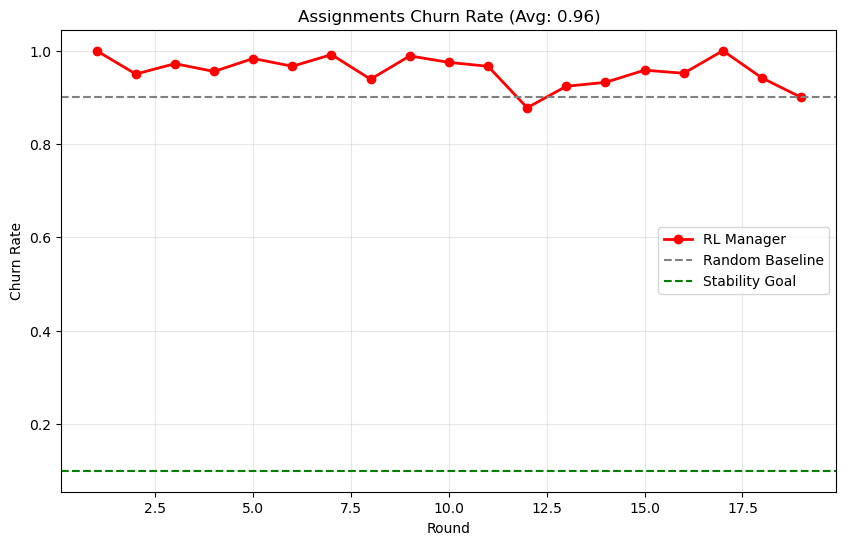

In [8]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt

FILENAME = "final_rl_results(2).csv"

def clean_and_parse(cell_text):
    """
    Fixes the 'np.float64(...)' error by removing the class wrapper 
    using Regular Expressions, then parses the dictionary.
    """
    if pd.isna(cell_text):
        return None
    
    text = str(cell_text).strip()
    
    # 1. Regex Fix: Change "np.float64(84.34)" -> "84.34"
    # Pattern: finds 'np.float64(' followed by any content, followed by ')'
    text = re.sub(r"np\.float64\((.*?)\)", r"\1", text)
    
    # 2. Also fix 'np.int64(...)' just in case
    text = re.sub(r"np\.int64\((.*?)\)", r"\1", text)

    try:
        return ast.literal_eval(text)
    except Exception as e:
        # If it still fails, print a snippet to debug
        # print(f"Failed to parse: {text[:50]}...") 
        return None

def calculate_churn_fixed():
    print(f"--- Loading {FILENAME} ---")
    try:
        df = pd.read_csv(FILENAME, index_col=0)
    except FileNotFoundError:
        print("❌ File not found.")
        return

    agent_cols = [c for c in df.columns if "Agent_" in c]
    print(f"✅ Loaded {len(df)} rounds. Fixing NumPy formatting issues...")

    churn_per_round = []
    
    for t in range(1, len(df)):
        round_churns = []
        
        for agent in agent_cols:
            curr_raw = df.at[t, agent]
            prev_raw = df.at[t-1, agent]
            
            # Use the new cleaner function
            curr_data = clean_and_parse(curr_raw)
            prev_data = clean_and_parse(prev_raw)
            
            if curr_data and prev_data:
                curr_arms = set(curr_data.get('assigned_arms', []))
                prev_arms = set(prev_data.get('assigned_arms', []))
                
                if len(curr_arms) > 0:
                    # Churn Calculation
                    kept = curr_arms.intersection(prev_arms)
                    churn = 1.0 - (len(kept) / len(curr_arms))
                    round_churns.append(churn)
        
        if round_churns:
            churn_per_round.append(np.mean(round_churns))
        else:
            churn_per_round.append(np.nan)

    # --- PLOTTING ---
    if not churn_per_round or np.isnan(np.nanmean(churn_per_round)):
        print("❌ No valid data found. The file format might be too broken.")
        return

    avg_churn = np.nanmean(churn_per_round)
    print(f"\n📊 Average Global Churn: {avg_churn:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(churn_per_round) + 1), churn_per_round, marker='o', color='red', linewidth=2, label='RL Manager')
    plt.axhline(y=0.9, color='gray', linestyle='--', label='Random Baseline')
    plt.axhline(y=0.1, color='green', linestyle='--', label='Stability Goal')
    
    plt.title(f"Assignments Churn Rate (Avg: {avg_churn:.2f})")
    plt.xlabel("Round")
    plt.ylabel("Churn Rate")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    calculate_churn_fixed()

--- Loading final_experiment_results.csv ---
✅ Loaded 20 rounds. Fixing NumPy formatting issues...

📊 Average Global Churn: 0.9011


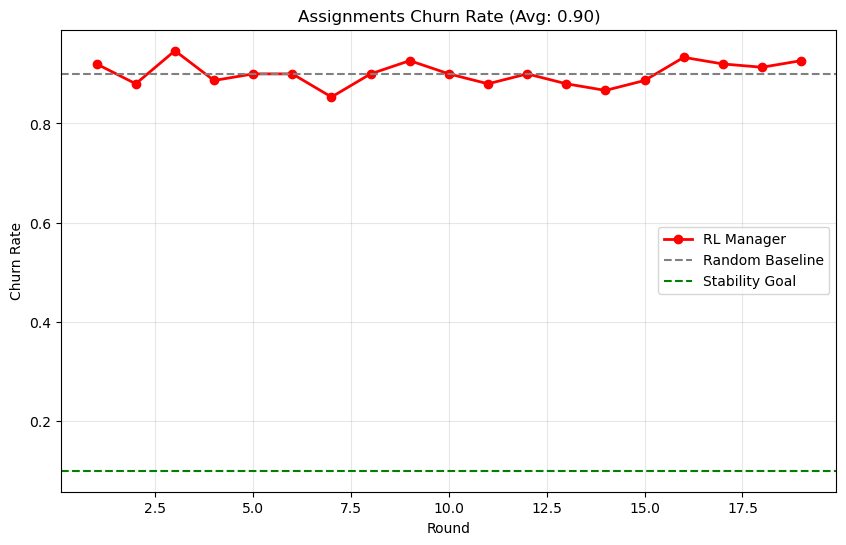

In [10]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt

FILENAME = "final_experiment_results.csv"

def clean_and_parse(cell_text):
    """
    Fixes the 'np.float64(...)' error by removing the class wrapper 
    using Regular Expressions, then parses the dictionary.
    """
    if pd.isna(cell_text):
        return None
    
    text = str(cell_text).strip()
    
    # 1. Regex Fix: Change "np.float64(84.34)" -> "84.34"
    # Pattern: finds 'np.float64(' followed by any content, followed by ')'
    text = re.sub(r"np\.float64\((.*?)\)", r"\1", text)
    
    # 2. Also fix 'np.int64(...)' just in case
    text = re.sub(r"np\.int64\((.*?)\)", r"\1", text)

    try:
        return ast.literal_eval(text)
    except Exception as e:
        # If it still fails, print a snippet to debug
        # print(f"Failed to parse: {text[:50]}...") 
        return None

def calculate_churn_fixed():
    print(f"--- Loading {FILENAME} ---")
    try:
        df = pd.read_csv(FILENAME, index_col=0)
    except FileNotFoundError:
        print("❌ File not found.")
        return

    agent_cols = [c for c in df.columns if "Agent_" in c]
    print(f"✅ Loaded {len(df)} rounds. Fixing NumPy formatting issues...")

    churn_per_round = []
    
    for t in range(1, len(df)):
        round_churns = []
        
        for agent in agent_cols:
            curr_raw = df.at[t, agent]
            prev_raw = df.at[t-1, agent]
            
            # Use the new cleaner function
            curr_data = clean_and_parse(curr_raw)
            prev_data = clean_and_parse(prev_raw)
            
            if curr_data and prev_data:
                curr_arms = set(curr_data.get('assigned_arms', []))
                prev_arms = set(prev_data.get('assigned_arms', []))
                
                if len(curr_arms) > 0:
                    # Churn Calculation
                    kept = curr_arms.intersection(prev_arms)
                    churn = 1.0 - (len(kept) / len(curr_arms))
                    round_churns.append(churn)
        
        if round_churns:
            churn_per_round.append(np.mean(round_churns))
        else:
            churn_per_round.append(np.nan)

    # --- PLOTTING ---
    if not churn_per_round or np.isnan(np.nanmean(churn_per_round)):
        print("❌ No valid data found. The file format might be too broken.")
        return

    avg_churn = np.nanmean(churn_per_round)
    print(f"\n📊 Average Global Churn: {avg_churn:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(churn_per_round) + 1), churn_per_round, marker='o', color='red', linewidth=2, label='RL Manager')
    plt.axhline(y=0.9, color='gray', linestyle='--', label='Random Baseline')
    plt.axhline(y=0.1, color='green', linestyle='--', label='Stability Goal')
    
    plt.title(f"Assignments Churn Rate (Avg: {avg_churn:.2f})")
    plt.xlabel("Round")
    plt.ylabel("Churn Rate")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    calculate_churn_fixed()

In [ ]:
#Remove temp
#make RL more deterministic

#.5 -> .6